# 앙상블 학습(Ensemble Learning)
- 여러 개의 분류기를 생성하고 예측을 결합하여 보다 정확한 최종 예측을 도출하는 기법
    - 보팅(Voting)
    - 배깅(Bagging)
    - 부스팅(Boosting)

## 부스팅(Boosting)
- 여러 개의 약한 학습기를 순차적으로 학습/예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식

# XGBoost(eXtra Gradient Boost)
- 일반적으로 다른 알고리즘보다 성능이 뛰어남
- GBM에 기반한다(GBM의 단점인 느린 수행 시간, 과적합 규제 부재 등의 문제 해결)
- 병렬 CPU 환경에서 병렬 학습 가능

In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd 
import numpy as np 
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [3]:
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
print(cancer.target_names)
print(df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [9]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'early_stoppings': 100
}
num_rounds = 400

wlist = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.607858	eval-logloss:0.621955
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.538104	eval-logloss:0.564527
[2]	train-logloss:0.480158	eval-logloss:0.514039
[3]	train-logloss:0.430618	eval-logloss:0.474653
[4]	train-logloss:0.38824	eval-logloss:0.440434
[5]	train-logloss:0.351201	eval-logloss:0.411449
[6]	train-logloss:0.319044	eval-logloss:0.385655
[7]	train-logloss:0.290841	eval-logloss:0.366191
[8]	train-logloss:0.265832	eval-logloss:0.348574
[9]	train-logloss:0.244273	eval-logloss:0.331956
[10]	train-logloss:0.224183	eval-logloss:0.312918
[11]	train-logloss:0.206098	eval-logloss:0.294394
[12]	train-logloss:0.190868	eval-logloss:0.283785
[13]	train-logloss:0.176515	eval-logloss:0.270118
[14]	train-logloss:0.164209	eval-logloss:0.263134
[15]	train-logloss:0.151813	eval-logloss:0.252434
[16]	train-logloss:0.140826	eval-logloss:0.241774
[17]	train-

In [10]:
pred_prob = xgb_model.predict(dtest)
print(pred_prob[:10])

preds = [1 if x > 0.5 else 0 for x in pred_prob]
print(preds[:10])

[9.9729580e-01 9.9243551e-01 9.8661101e-01 4.0627190e-01 5.8598703e-01
 3.0549802e-04 9.9930108e-01 9.9984121e-01 9.9909651e-01 9.9961323e-01]
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_prob=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print(confusion)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall:' , recall)
    print('f1: ', f1)
    print('roc_auc: ', roc_auc)

In [12]:
get_clf_eval(y_test, preds, pred_prob)

[[37  4]
 [ 3 70]]
accuracy:  0.9385964912280702
precision:  0.9459459459459459
recall: 0.958904109589041
f1:  0.9523809523809523
roc_auc:  0.9306715669896425


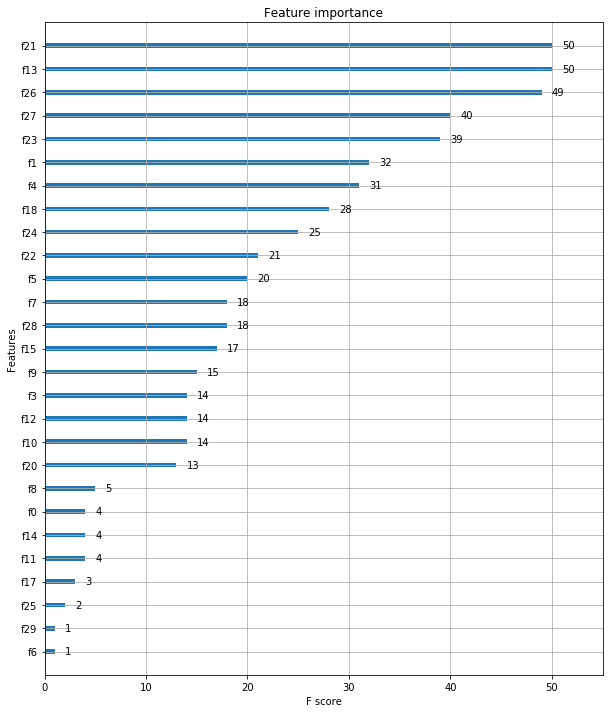

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

### n_estimators = 400

In [21]:
# early_stopping_rounds 설정 X
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
pred_prob = xgb.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_prob)

[[37  4]
 [ 3 70]]
accuracy:  0.9385964912280702
precision:  0.9459459459459459
recall: 0.958904109589041
f1:  0.9523809523809523
roc_auc:  0.9306715669896425


In [24]:
# early_stopping_rounds = 100
xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals)
pred100 = xgb.predict(X_test)
pred_prob100 = xgb.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.621955
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.564526
[2]	validation_0-logloss:0.51404
[3]	validation_0-logloss:0.474653
[4]	validation_0-logloss:0.440434
[5]	validation_0-logloss:0.411449
[6]	validation_0-logloss:0.385656
[7]	validation_0-logloss:0.366191
[8]	validation_0-logloss:0.348574
[9]	validation_0-logloss:0.331956
[10]	validation_0-logloss:0.312918
[11]	validation_0-logloss:0.294394
[12]	validation_0-logloss:0.283785
[13]	validation_0-logloss:0.270118
[14]	validation_0-logloss:0.263134
[15]	validation_0-logloss:0.252434
[16]	validation_0-logloss:0.241774
[17]	validation_0-logloss:0.236396
[18]	validation_0-logloss:0.227689
[19]	validation_0-logloss:0.226057
[20]	validation_0-logloss:0.220605
[21]	validation_0-logloss:0.214235
[22]	validation_0-logloss:0.206155
[23]	validation_0-logloss:0.20124
[24]	validation_0-logloss:0.197784
[25]	validation_0-logloss:0.194607
[26]	validation_0-logloss:0.18920

In [25]:
get_clf_eval(y_test, pred100, pred_prob100)

[[38  3]
 [ 4 69]]
accuracy:  0.9385964912280702
precision:  0.9583333333333334
recall: 0.9452054794520548
f1:  0.9517241379310345
roc_auc:  0.9360173738723689


### 아무리 해도 오르지 않는 것 보면 내 컴퓨터의 한계는 여기가지인가보다

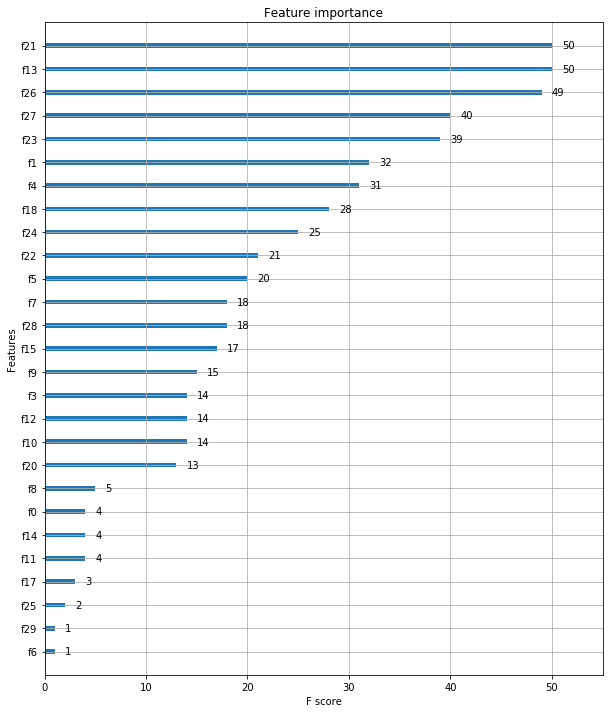

In [27]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)